* 请在环境变量中设置`DB_URI`指向数据库

In [1]:
%matplotlib inline
import os
import datetime as dt
import numpy as np
import pandas as pd
from PyFin.api import *
from alphamind.api import *
from matplotlib import pyplot as plt

plt.style.use('ggplot')
dt.datetime.now()

datetime.datetime(2019, 2, 10, 0, 16, 56, 354078)

In [2]:
start_date = '2017-04-10'
end_date = '2018-04-09'

freq = '5b'
horizon = map_freq(freq)
neutralized_risk = risk_styles + industry_styles
universe = Universe('zz500')
data_source = os.environ['DB_URI']
offset = 1
method = 'ls'
industry_name = 'sw'
industry_level = 1

risk_model = 'short'
executor = NaiveExecutor()
ref_dates = makeSchedule(start_date, end_date, freq, 'china.sse')
engine = SqlEngine(data_source)

In [8]:
alpha_factors = {
    'f01': LAST('EPS'),
    'f02': LAST('ROE')
    }

weights = dict(f01=1.0,
               f02=1.0,
              )

alpha_model = ConstLinearModel(features=alpha_factors, weights=weights)

def predict_worker(params):
    data_meta = DataMeta(freq=freq,
                         universe=universe,
                         batch=1,
                         neutralized_risk=neutralized_risk,
                         risk_model='short',
                         pre_process=[winsorize_normal, standardize],
                         post_process=[standardize],
                         warm_start=0,
                         data_source=data_source)
    ref_date, model = params
    er, _ = predict_by_model(ref_date, model, data_meta)
    return er

In [9]:
%%time
predicts = [predict_worker((d.strftime('%Y-%m-%d'), alpha_model)) for d in ref_dates]

Wall time: 1min 9s


In [10]:
industry_names = industry_list(industry_name, industry_level)
industry_total = engine.fetch_industry_matrix_range(universe, dates=ref_dates, category=industry_name, level=industry_level)

previous_pos = pd.DataFrame()
rets = []
turn_overs = []
leverags = []

for i, ref_date in enumerate(ref_dates):
    ref_date = ref_date.strftime('%Y-%m-%d')
    industry_matrix = industry_total[industry_total.trade_date == ref_date]
    
    res = industry_matrix.dropna()
    codes = res.code.values.tolist()
        
    er = predicts[i].loc[codes].values
    
    alpha_logger.info('{0} full re-balance: {1}'.format(ref_date, len(er)))
    target_pos, _ = er_portfolio_analysis(er,
                                          industry_matrix.industry_name.values,
                                          None,
                                          None,
                                          False,
                                          None,
                                          method=method)
        
    target_pos['code'] = codes
    turn_over, executed_pos = executor.execute(target_pos=target_pos)

    executed_codes = executed_pos.code.tolist()
    dx_returns = engine.fetch_dx_return(ref_date, executed_codes, horizon=horizon, offset=offset)
    result = pd.merge(executed_pos, dx_returns, on=['code'])

    leverage = result.weight.abs().sum()

    ret = result.weight.values @ (np.exp(result.dx.values) - 1.)
    rets.append(np.log(1. + ret))
    executor.set_current(executed_pos)
    turn_overs.append(turn_over)
    leverags.append(leverage)

    previous_pos = executed_pos
    alpha_logger.info('{0} is finished'.format(ref_date))

2019-02-10 00:19:34,241 - ALPHA_MIND - INFO - 2017-04-10 full re-balance: 500
2019-02-10 00:19:34,503 - ALPHA_MIND - INFO - 2017-04-10 is finished
2019-02-10 00:19:34,508 - ALPHA_MIND - INFO - 2017-04-17 full re-balance: 500
2019-02-10 00:19:34,796 - ALPHA_MIND - INFO - 2017-04-17 is finished
2019-02-10 00:19:34,802 - ALPHA_MIND - INFO - 2017-04-24 full re-balance: 500
2019-02-10 00:19:35,044 - ALPHA_MIND - INFO - 2017-04-24 is finished
2019-02-10 00:19:35,057 - ALPHA_MIND - INFO - 2017-05-02 full re-balance: 500
2019-02-10 00:19:35,288 - ALPHA_MIND - INFO - 2017-05-02 is finished
2019-02-10 00:19:35,301 - ALPHA_MIND - INFO - 2017-05-09 full re-balance: 500
2019-02-10 00:19:35,561 - ALPHA_MIND - INFO - 2017-05-09 is finished
2019-02-10 00:19:35,578 - ALPHA_MIND - INFO - 2017-05-16 full re-balance: 500
2019-02-10 00:19:35,839 - ALPHA_MIND - INFO - 2017-05-16 is finished
2019-02-10 00:19:35,849 - ALPHA_MIND - INFO - 2017-05-23 full re-balance: 500
2019-02-10 00:19:36,085 - ALPHA_MIND - I

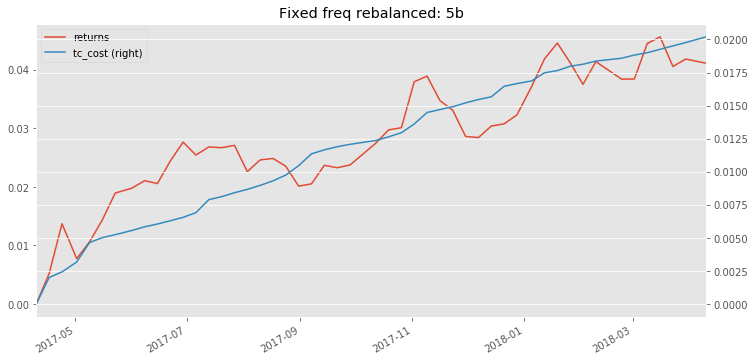

In [11]:
ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=ref_dates)
ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], freq)] = 0.
ret_df = ret_df.shift(1)
ret_df.iloc[0] = 0.
ret_df['tc_cost'] = ret_df.turn_over * 0.002

ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                             title='Fixed freq rebalanced: {0}'.format(freq),
                                             secondary_y='tc_cost')